In [1]:
import argparse

import torch
import os

import pandas as pd
import geopandas as gpd
import datetime
import pickle
from shapely import wkt
import json
import numpy as np
from json import JSONEncoder

from tqdm import tqdm

from easydict import EasyDict as edict
from sklearn.preprocessing import OrdinalEncoder

from loc_predict.models.markov import markov_transition_prob
from utils.utils import load_data, setup_seed, load_config, _split_dataset
from utils.dist_util import load_state_dict
from sklearn.linear_model import LinearRegression
from mechanistic.dataloader import load_data_mech
from mechanistic.models import EPR
from mechanistic.container import ScalesOptim

from trackintel.geogr import point_haversine_dist
import powerlaw

C:\ProgramData\Anaconda3\envs\gene\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from mechanistic import container

In [3]:
import matplotlib as mpl
def setup_mpl():
    mpl.rc('font', size=12)
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['xtick.labelsize'] = 'small'
    mpl.rcParams['ytick.labelsize'] = 'small'

    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.minor.width'] = 1
    mpl.rcParams['xtick.major.size'] = 3
    mpl.rcParams['ytick.major.size'] = 3
    mpl.rcParams['xtick.minor.size'] = 1.5
    mpl.rcParams['ytick.minor.size'] = 1.5
    mpl.rcParams['axes.linewidth'] = 1
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.top']=True
    mpl.rcParams['ytick.right']=True
    mpl.rcParams['mathtext.default']='regular'
    mpl.rcParams['xtick.major.pad']='2.3'
    mpl.rcParams['ytick.major.pad']='2.3'
    mpl.rcParams['axes.labelpad']= 2
    mpl.rcParams['figure.dpi'] = 400

    to_rgba = mpl.colors.ColorConverter().to_rgba
setup_mpl()

In [4]:
def get_train_test_mech(sp, all_locs=None):
    sp.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)
    sp.drop(columns={"started_at", "finished_at"}, inplace=True)
    sp["idx"] = sp.groupby("user_id").cumcount().add(1)

    # encoder user, 0 reserved for padding
    enc = OrdinalEncoder(dtype=np.int64)
    sp["user_id"] = enc.fit_transform(sp["user_id"].values.reshape(-1, 1)) + 1

    # split the datasets, user dependent 0.7, 0.2, 0.1
    train_data, vali_data, test_data = _split_dataset(sp)

    # encode unseen locations in validation and test into 0
    enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
        all_locs["loc_id"].values.reshape(-1, 1)
    )
    # add 1 to account for 0 padding
    all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

    train_data["location_id"] = enc.transform(train_data["location_id"].values.reshape(-1, 1)) + 1
    vali_data["location_id"] = enc.transform(vali_data["location_id"].values.reshape(-1, 1)) + 1
    test_data["location_id"] = enc.transform(test_data["location_id"].values.reshape(-1, 1)) + 1

    return train_data, vali_data, test_data, all_locs


def get_data_mech(type):
    sp = pd.read_csv(os.path.join(f"./data/sp_{type}.csv"), index_col="id")
    loc = pd.read_csv(os.path.join("./data/loc_s2_level10_13.csv"), index_col="id")

    sp = load_data(sp, loc)

    # get all possible locations
    all_locs = pd.read_csv("./data/s2_loc_visited_level10_13.csv", index_col="id")
    all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
    all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
    # transform to projected coordinate systems
    # all_locs = all_locs.to_crs("EPSG:2056")

    train_data, vali_data, test_data, all_locs = get_train_test_mech(sp, all_locs=all_locs)
    print(
        f"Max loc id {all_locs.loc_id.max()}, min loc id {all_locs.loc_id.min()}, unique loc id:{all_locs.loc_id.unique().shape[0]}"
    )

    return train_data, vali_data, test_data, all_locs

In [99]:
# initialization
config = load_config("./config/mechanistic.yml")
config = edict(config)

setup_seed(config.seed)
timestamp_now = int(datetime.datetime.now().timestamp())

train_df, vali_df, test_df, all_locs_df = get_data_mech(type="tiny")

Max loc id 14881, min loc id 1, unique loc id:14881


In [103]:
df = pd.concat([train_df, vali_df]).sort_values(by=["user_id", "start_day", "start_min"])

In [114]:
for curr_user in df["user_id"].unique():
    curr_df = df.loc[df["user_id"] == curr_user].copy()

    # stop_locations
    user_unq_locs = np.sort(curr_df["location_id"].unique())
    locs_geom = all_locs_df.loc[all_locs_df["loc_id"].isin(user_unq_locs)]
    lat_lng = np.stack([locs_geom.geometry.y.values, locs_geom.geometry.x.values]).T

    # labels
    labels = curr_df['location_id'].map(dict(zip(user_unq_locs,range(len(user_unq_locs))))).values
    
    

    final_series, _, likelihoods, _, final_sizes, _, _ = ScalesOptim(labels = labels, 
                                                                     stop_locations= lat_lng, bootstrap=True, min_dist=1.2, verbose=False).find_best_scale()
    
    # print(final_series)

Found 2 scales
Found 3 scales
Found 1 scales
Found 2 scales
Found 2 scales
Found 3 scales
Found 2 scales
Found 2 scales
Found 2 scales
Found 2 scales


KeyboardInterrupt: 

In [116]:
curr_df = df.loc[df["user_id"] == df["user_id"].unique()[1]].copy()

# stop_locations
user_unq_locs = np.sort(curr_df["location_id"].unique())
locs_geom = all_locs_df.loc[all_locs_df["loc_id"].isin(user_unq_locs)]
lat_lng = np.stack([locs_geom.geometry.y.values, locs_geom.geometry.x.values]).T

# labels
labels = curr_df['location_id'].map(dict(zip(user_unq_locs,range(len(user_unq_locs))))).values



final_series, _, likelihoods, _, final_sizes, _, _ = ScalesOptim(labels = labels, 
                                                                 stop_locations= lat_lng, bootstrap=True, min_dist=1.2, verbose=False).find_best_scale()

Found 3 scales


In [119]:
from collections import defaultdict
from scipy.spatial import ConvexHull
def get_container_labels(series):
    """For a multilevel walk, figure out which stop locations are in which containers at each scale

    Input
    -----
        series : list of lists

    Output
    ------
        container_labels : dict of dicts of lists
            The first level is scale, so `container_labels.keys()` will be something like `[2, 3, 4, 5]`.
            The second level is the containers in a given scale, yielding a list of all contained stop labels.

    Example
    -------
        >>> contaier_hierarchy = get_container_hierarchy(series)
        >>> contaier_hierarchy
        {   # scale
            2: {
                # container: labels
                0: [0, 1, 2, 5, 23, ...],
                ...
            }, 
            3: ...
        }
    """
    scale = len(series[0])
    containers = np.unique(series, axis=0)
    container_hiararchy = defaultdict(set)
    for cell in containers:
        for s in range(scale-1):
            container_hiararchy[tuple(cell[:s+1])].add(cell[-1])
    return container_hiararchy

def convex_hull(points, to_return='points'):
    """Return the convex hull of a collection of points."""
    points = np.unique(points, axis=0)
    if len(points) <= 2:
        raise Exception("Number of unique points must be larger than 2.")
    else:
        hull = ConvexHull(points)
    if to_return == "points":
        return points[hull.vertices, :]
    if to_return == "area":
        return hull.area
    if to_return == "volume":
        return hull.volume
    if to_return == "geoarea":
        from area import area
        return area({'type':'Polygon','coordinates':[points[hull.vertices].tolist()]})
        
series = np.array(final_series)
stop_labels = lat_lng
series = series[:-1][(series[:-1]!=series[1:]).any(axis = 1)]

# Get the hierarchy of cells that we want to plot
container_labels = get_container_labels(series)
n_scales = len(series[0])



# Convert each cell to a convex hull
cell_hulls = defaultdict(dict)
for cell, stop_labels in container_labels.items():
    points = [lat_lng[label] for label in stop_labels]
    while True:
        try:
            cell_hulls[n_scales-len(cell)+1][cell] = convex_hull(np.array(points))
            break
        except: # QhullError
            points.append(points[-1] + (np.random.random(size=2)-0.5) * 1e-4)

In [120]:
# from scipy.spatial.distance import pdist
def haversine(points_a, points_b, radians=False):
    """ 
    Calculate the great-circle distance bewteen points_a and points_b
    points_a and points_b can be a single points or lists of points.

    Author: Piotr Sapiezynski
    Source: https://github.com/sapiezynski/haversinevec

    Using this because it is vectorized (stupid fast).
    """
    def _split_columns(array):
        if array.ndim == 1:
            return array[0], array[1] # just a single row
        else:
            return array[:,0], array[:,1]

    if radians:
        lat1, lon1 = _split_columns(points_a)
        lat2, lon2 = _split_columns(points_b)

    else:
    # convert all latitudes/longitudes from decimal degrees to radians
        lat1, lon1 = _split_columns(np.radians(points_a))
        lat2, lon2 = _split_columns(np.radians(points_b))

    # calculate haversine
    lat = lat2 - lat1
    lon = lon2 - lon1

    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon * 0.5) ** 2
    h = 2 * 6371e3 * np.arcsin(np.sqrt(d))
    return h  # in meters


def haversine_pdist(points, radians=False):
    """ 
    Calculate the great-circle distance bewteen each pair in a set of points.
    
    Author: Piotr Sapiezynski
    Source: https://github.com/sapiezynski/haversinevec

    Input
    -----
        points : array-like (shape=(N, 2))
            (lat, lon) in degree or radians (default is degree)

    Output
    ------
        result : array-like (shape=(N*(N-1)//2, ))
    """ 
    c = points.shape[0]
    result = np.zeros((c*(c-1)//2,), dtype=np.float64)
    vec_idx = 0
    if not radians:
        points = np.radians(points)
    for idx in range(0, c-1):
        ref = points[idx]
        temp = haversine(points[idx+1:c,:], ref, radians=True)
        result[vec_idx:vec_idx+temp.shape[0]] = temp
        vec_idx += temp.shape[0]
    return result
    
ls2 = defaultdict(list)
for item in cell_hulls.items():
    for item2 in item[1].items():
        ls2[item[0]].append(haversine_pdist(item2[1]).max())

In [121]:
ls2

defaultdict(list,
            {3: [6675.387430165489, 21630.066887454173],
             2: [3290.6089001964865,
              4024.9783888597276,
              1350.2607311234983,
              3.971517566403636,
              3.99284854127773]})

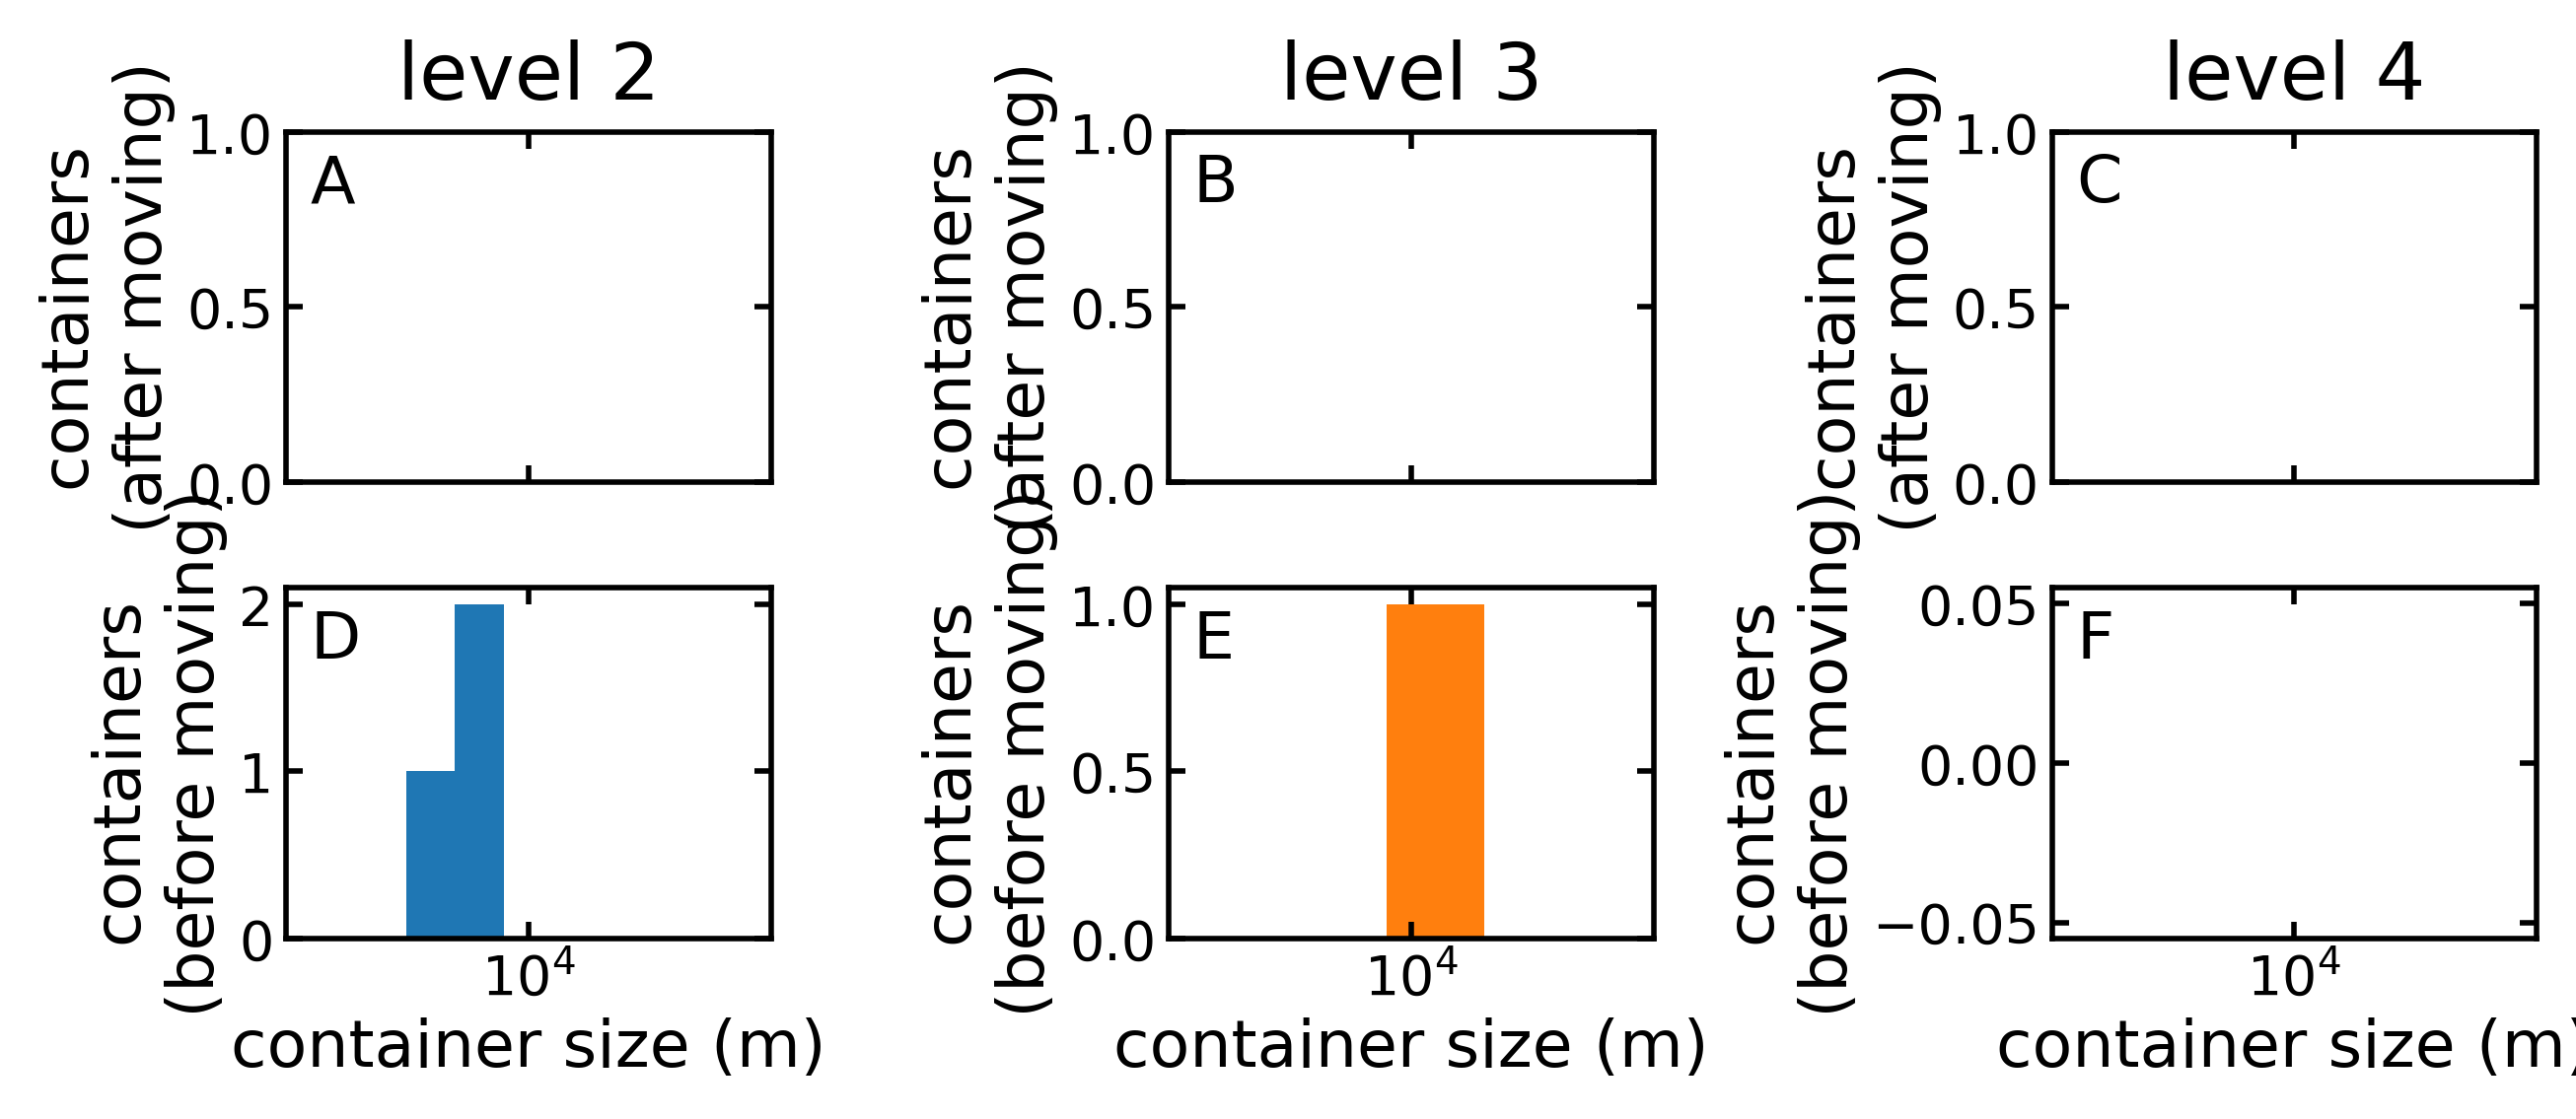

In [122]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,3,figsize=(6.69,3),sharex='col')

ax[0][2].set_title('level 4')
ax[1][2].set_xlabel('container size (m)')

# ax[0][2].hist(ls[4],bins =np.logspace(2,6,10),color = 'C2')
ax[1][2].hist(ls2[4],bins =np.logspace(2,6,10),color = 'C2')
ax[0][2].set_xscale('log')
ax[1][2].set_ylabel('containers \n (before moving)')
ax[0][2].set_ylabel('containers \n (after moving)')


ax[0][1].set_title('level 3')

# ax[0][1].hist(ls[3],bins =np.logspace(2,6,10),color = 'C1')
ax[1][1].hist(ls2[3],bins =np.logspace(2,6,10),color = 'C1')
ax[0][1].set_xscale('log')
ax[1][1].set_xlabel('container size (m)')
ax[1][1].set_ylabel('containers \n (before moving)')
ax[0][1].set_ylabel('containers \n (after moving)')


ax[0][0].set_title('level 2')

# ax[0][0].hist(ls[2],bins =np.logspace(2,6,10),color = 'C0')
ax[1][0].hist(ls2[2],bins =np.logspace(2,6,10),color = 'C0')
ax[0][0].set_xscale('log')
ax[1][0].set_xlabel('container size (m)')
ax[1][0].set_ylabel('containers \n (before moving)')
ax[0][0].set_ylabel('containers \n (after moving)')

import string
for n, a in enumerate(ax.flatten()):

    a.text(0.05, 0.8, string.ascii_uppercase[n], transform=a.transAxes)
    
fig.tight_layout()

In [123]:
import folium
def haversine(points_a, points_b, radians=False):
    """
    Calculate the great-circle distance bewteen points_a and points_b
    points_a and points_b can be a single points or lists of points.

    Author: Piotr Sapiezynski
    Source: https://github.com/sapiezynski/haversinevec

    Using this because it is vectorized (stupid fast).
    """

    def _split_columns(array):
        if array.ndim == 1:
            return array[0], array[1]  # just a single row
        else:
            return array[:, 0], array[:, 1]

    if radians:
        lat1, lon1 = _split_columns(points_a)
        lat2, lon2 = _split_columns(points_b)

    else:
        # convert all latitudes/longitudes from decimal degrees to radians
        lat1, lon1 = _split_columns(np.radians(points_a))
        lat2, lon2 = _split_columns(np.radians(points_b))

    # calculate haversine
    lat = lat2 - lat1
    lon = lon2 - lon1

    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon * 0.5) ** 2
    h = 2 * 6371e3 * np.arcsin(np.sqrt(d))
    return h  # in meters

def plot_solution_on_world_map(series, stop_locations, distance_func=haversine, filename = None):
    """Plot folium map with nested container.
    
    Input
    -----
        series : list of lists
            Important! Lowest cell index must map to row in `stop_locations`!
        stop_locations : np.array (`stop_locations.shape[1] == 2`)
        distance_func : function
        
    Example
    -------
        >>> plot_solution_on_world_map(best_branch.series, stop_locations, distance_func=euclidean)
    """
    
    if len(series[0])==1:
        print('Only one scale found: could not print map')
        return None
    series = series[:-1][(series[:-1]!=series[1:]).any(axis = 1)]

    # Get the hierarchy of cells that we want to plot
    container_labels = get_container_labels(series)
    n_scales = len(series[0])

    # HACK for non-spherical-coord points to plot on geo map anyway
    if distance_func != haversine:
        stop_locations = stop_locations / stop_locations.max()
        stop_locations[:, 1] += 90

    # Convert each cell to a convex hull
    cell_hulls = defaultdict(dict)
    for cell, stop_labels in container_labels.items():
        points = [stop_locations[label] for label in stop_labels]
        while True:
            try:
                cell_hulls[n_scales-len(cell)+1][cell] = convex_hull(np.array(points))
                break
            except: # QhullError
                points.append(points[-1] + (np.random.random(size=2)-0.5) * 1e-4)
                
    # Styling function used by folium
    def style_function(feature):
        return {"fillColor": feature["properties"]["color"], "color": feature["properties"]["color"], "weight": 1, "fillOpacity": 0.1}

    # Build GeoJSON valid dictionary
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    colors = colors+['#000000',"#ff0000",'#800080']

    polygons = {"type": "FeatureCollection", "features": []}
    for s in sorted(cell_hulls.keys(), reverse=True):
        polygons["features"].append({
            "type": "Feature",
            "properties": {"color": colors[s-2]},
            "geometry": {
                "type": "Polygon",
                "coordinates": []
            }
        })
        for cell in cell_hulls[s].values():
            polygons["features"][-1]["geometry"]["coordinates"].append(
                cell[:, ::-1].tolist()
            )
    
    # Initiate folium map
    m = folium.Map(np.median(stop_locations, 0).tolist(), zoom_start=8, tiles="cartodbpositron")

    # Add data to it
    folium.GeoJson(
        polygons,
        style_function=style_function
    ).add_to(m)

    #trip_scale_labels = get_scale_labels(series)
    #for l1,l2,t in zip(series[:-1],series[1:],trip_scale_labels):
    #    c1 = stop_locations[l1[-1]]
    #    c2 = stop_locations[l2[-1]]
    #    folium.PolyLine([c1,c2], color = colors[t-1], weight = 0.5).add_to( m )
        
    #for coord in stop_locations:
    #    folium.CircleMarker(location=[ coord[0], coord[1] ], radius = 1, color = 'black').add_to( m )
    

    
    # Return it!
            
    if filename!=None:
        m.save(filename)
        
    else:
        return m

plot_solution_on_world_map(np.array(final_series), lat_lng)

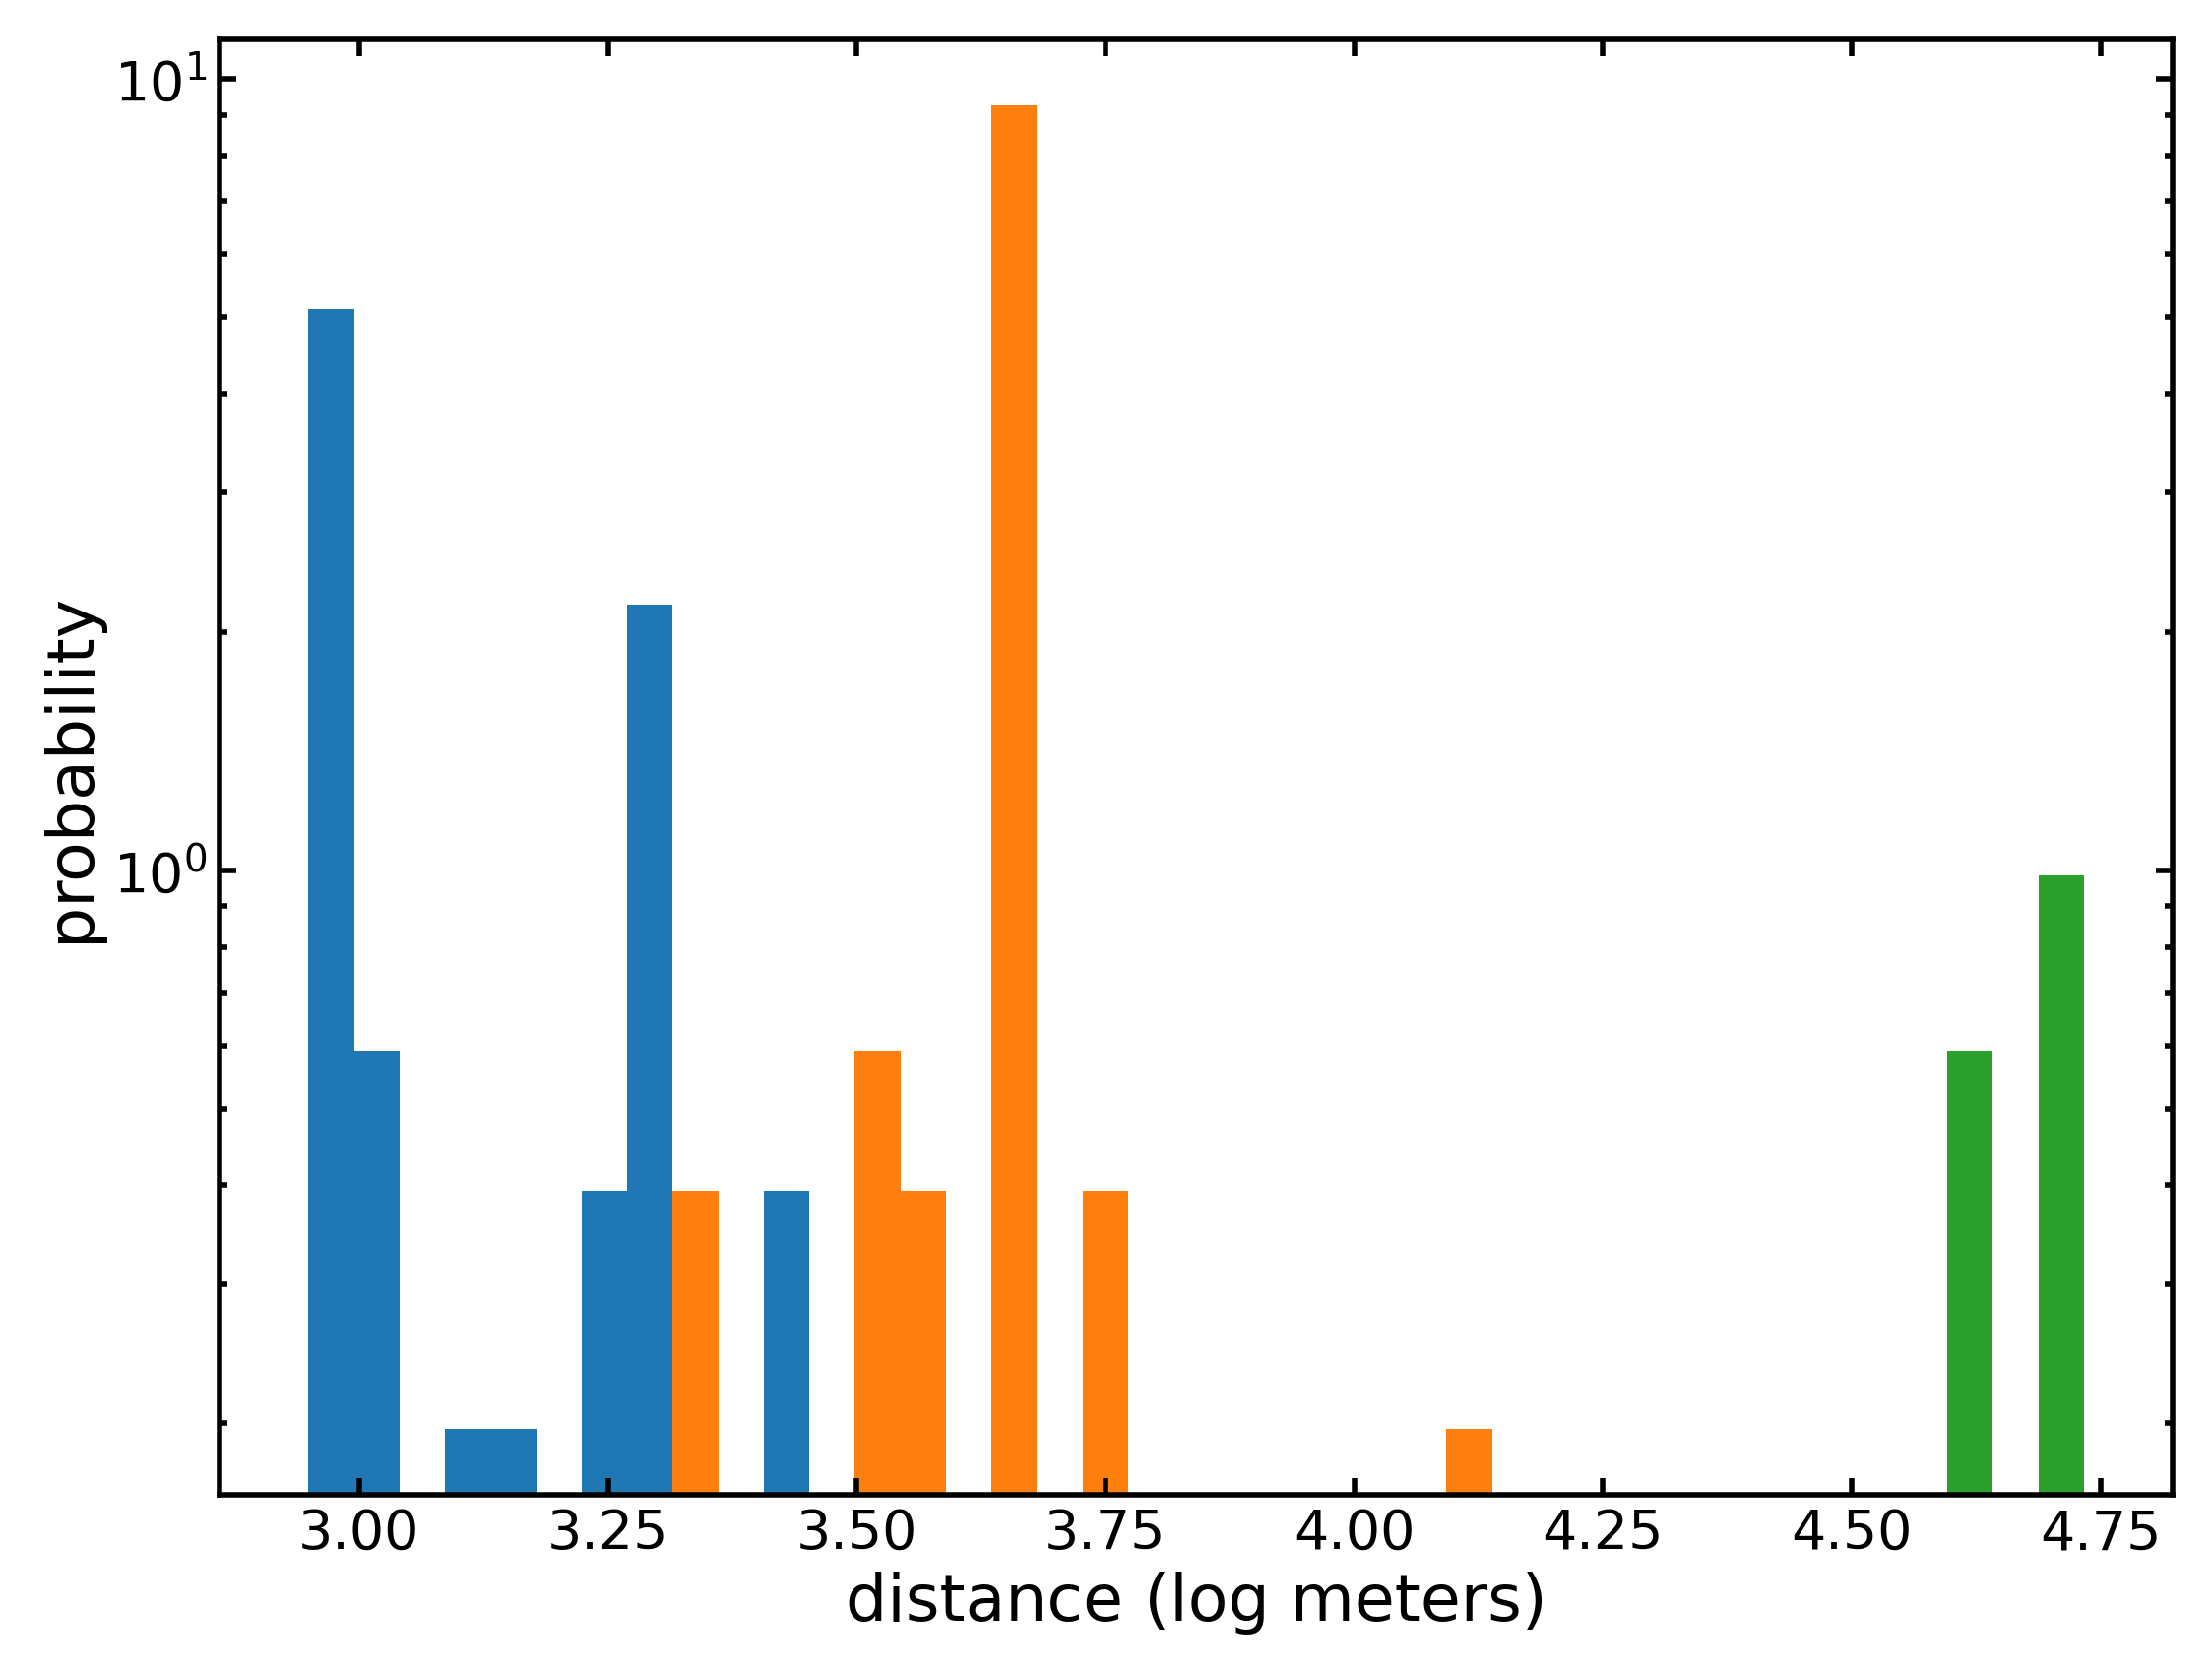

In [124]:
def plot_scales_histogram(series, stop_locations, colors=None, log_dist=True, density=True, distance_func=haversine):
    """Plot histogram of trip distances for all scales.
    
    Bars are colored by the average scales inside.
    
    Input
    -----
        series : list of lists
            Important! Lowest cell index must map to row in `stop_locations`!
        stop_locations : np.array (`stop_locations.shape[1] == 2`)
        colors : list of hex color strings (optional colorscheme)
       
    
    """
    nbins = 40

    # Get scale and distances of trips
    trip_scale_labels = np.array(get_scale_labels(series))
    distances = np.array([
        distance_func(stop_locations[step0[-1]], stop_locations[step1[-1]])
        for step0, step1 in zip(series[:-1], series[1:])
    ])
    
    # Remove trips with distance zero (they should not exist, but hey)
    trip_scale_labels = trip_scale_labels[distances>0]
    distances = distances[distances>0]
    
    if log_dist:
        distances = np.log10(distances)

    # Decide on some bin edges
    if not log_dist:
        hist_bins = np.logspace(np.log10(min(distances)), np.log10(max(distances)), nbins)
    else:
        hist_bins = np.linspace(min(distances), max(distances), nbins)

    # Get the bin id of each trip
    bin_ids = np.digitize(distances, bins=hist_bins)

    # Create a map between bin_id and the scale of trips inside the bin
    bin_scales = defaultdict(list)
    for bin_id, scale in zip(bin_ids, trip_scale_labels):
        bin_scales[bin_id].append(scale)

    # Order of colors that we like
    if colors is None or len(colors) < len(series[0]):
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        colors = colors+['#000000',"#ff0000",'#800080']
    
    # Compute the bar colors
    barcolors = [
        colormixer([colors[s-1] for s in scales])
        for bin_id, scales in sorted(bin_scales.items(), key=lambda kv: kv[0])
    ]

    # Plot the damn histogram!
    densities, _, patches = plt.hist(distances, bins=hist_bins, density=density)
    if not log_dist: plt.xscale("log")
    plt.yscale("log")

    # Recolor each histogram bar
    i = 0
    for density, patch in zip(densities, patches):
        if density == 0: continue
        patch.set_facecolor(barcolors[i])
        i += 1

def get_scale_labels(series):
    """For each step in a multilevel walk, get the scale.

    Input
    -----
        series : list of lists

    Output
    ------
        out : list (`len(out) == len(series)`)

    Example
    -------
        >>> scale_labels = get_scale_labels(series)
        >>> scale_labels
        [1, 1, 1, 1, 1, 3, 2, 1, 1, 1, ...
    """
    n_scales = len(series[0])
    series = np.array(series)
    return [
        n_scales - np.min(np.where(list(c_i)+[True])[0])
        for c_i in series[:-1] != series[1:]
    ]

def colormixer(colors, weights=None):
    """Take array of colors in hex format and return the average color.
    
    Input
    -----
        colors : array of hex values
    
    Example
    -------
        >>> colormixer(['#3E1F51', '#FEE824', '#1F908B'])
        '#4af134'
    """
    def _to_hex(v):
        v_hex = hex(v)[2:]
        if len(v_hex) == 1:
            v_hex = "0" + v_hex
        return v_hex

    # Compute mean intensities for red, green and blue
    if weights is None:
        r = int(np.mean([int(c[1:3], 16) for c in colors]))
        g = int(np.mean([int(c[3:5], 16) for c in colors]))
        b = int(np.mean([int(c[5:7], 16) for c in colors]))
    else:
        r = int(sum([int(c[1:3], 16) * w for c, w in zip(colors, weights)]) / sum(weights))
        g = int(sum([int(c[3:5], 16) * w for c, w in zip(colors, weights)]) / sum(weights))
        b = int(sum([int(c[5:7], 16) * w for c, w in zip(colors, weights)]) / sum(weights))
    
    # Take mean of each and convert back to hex
    return '#' + _to_hex(r) + _to_hex(g) + _to_hex(b)

plt.figure()
plot_scales_histogram(final_series, lat_lng)
plt.xlabel('distance (log meters)')
plt.ylabel('probability')
plt.show()

Text(0, 0.5, '-log L')

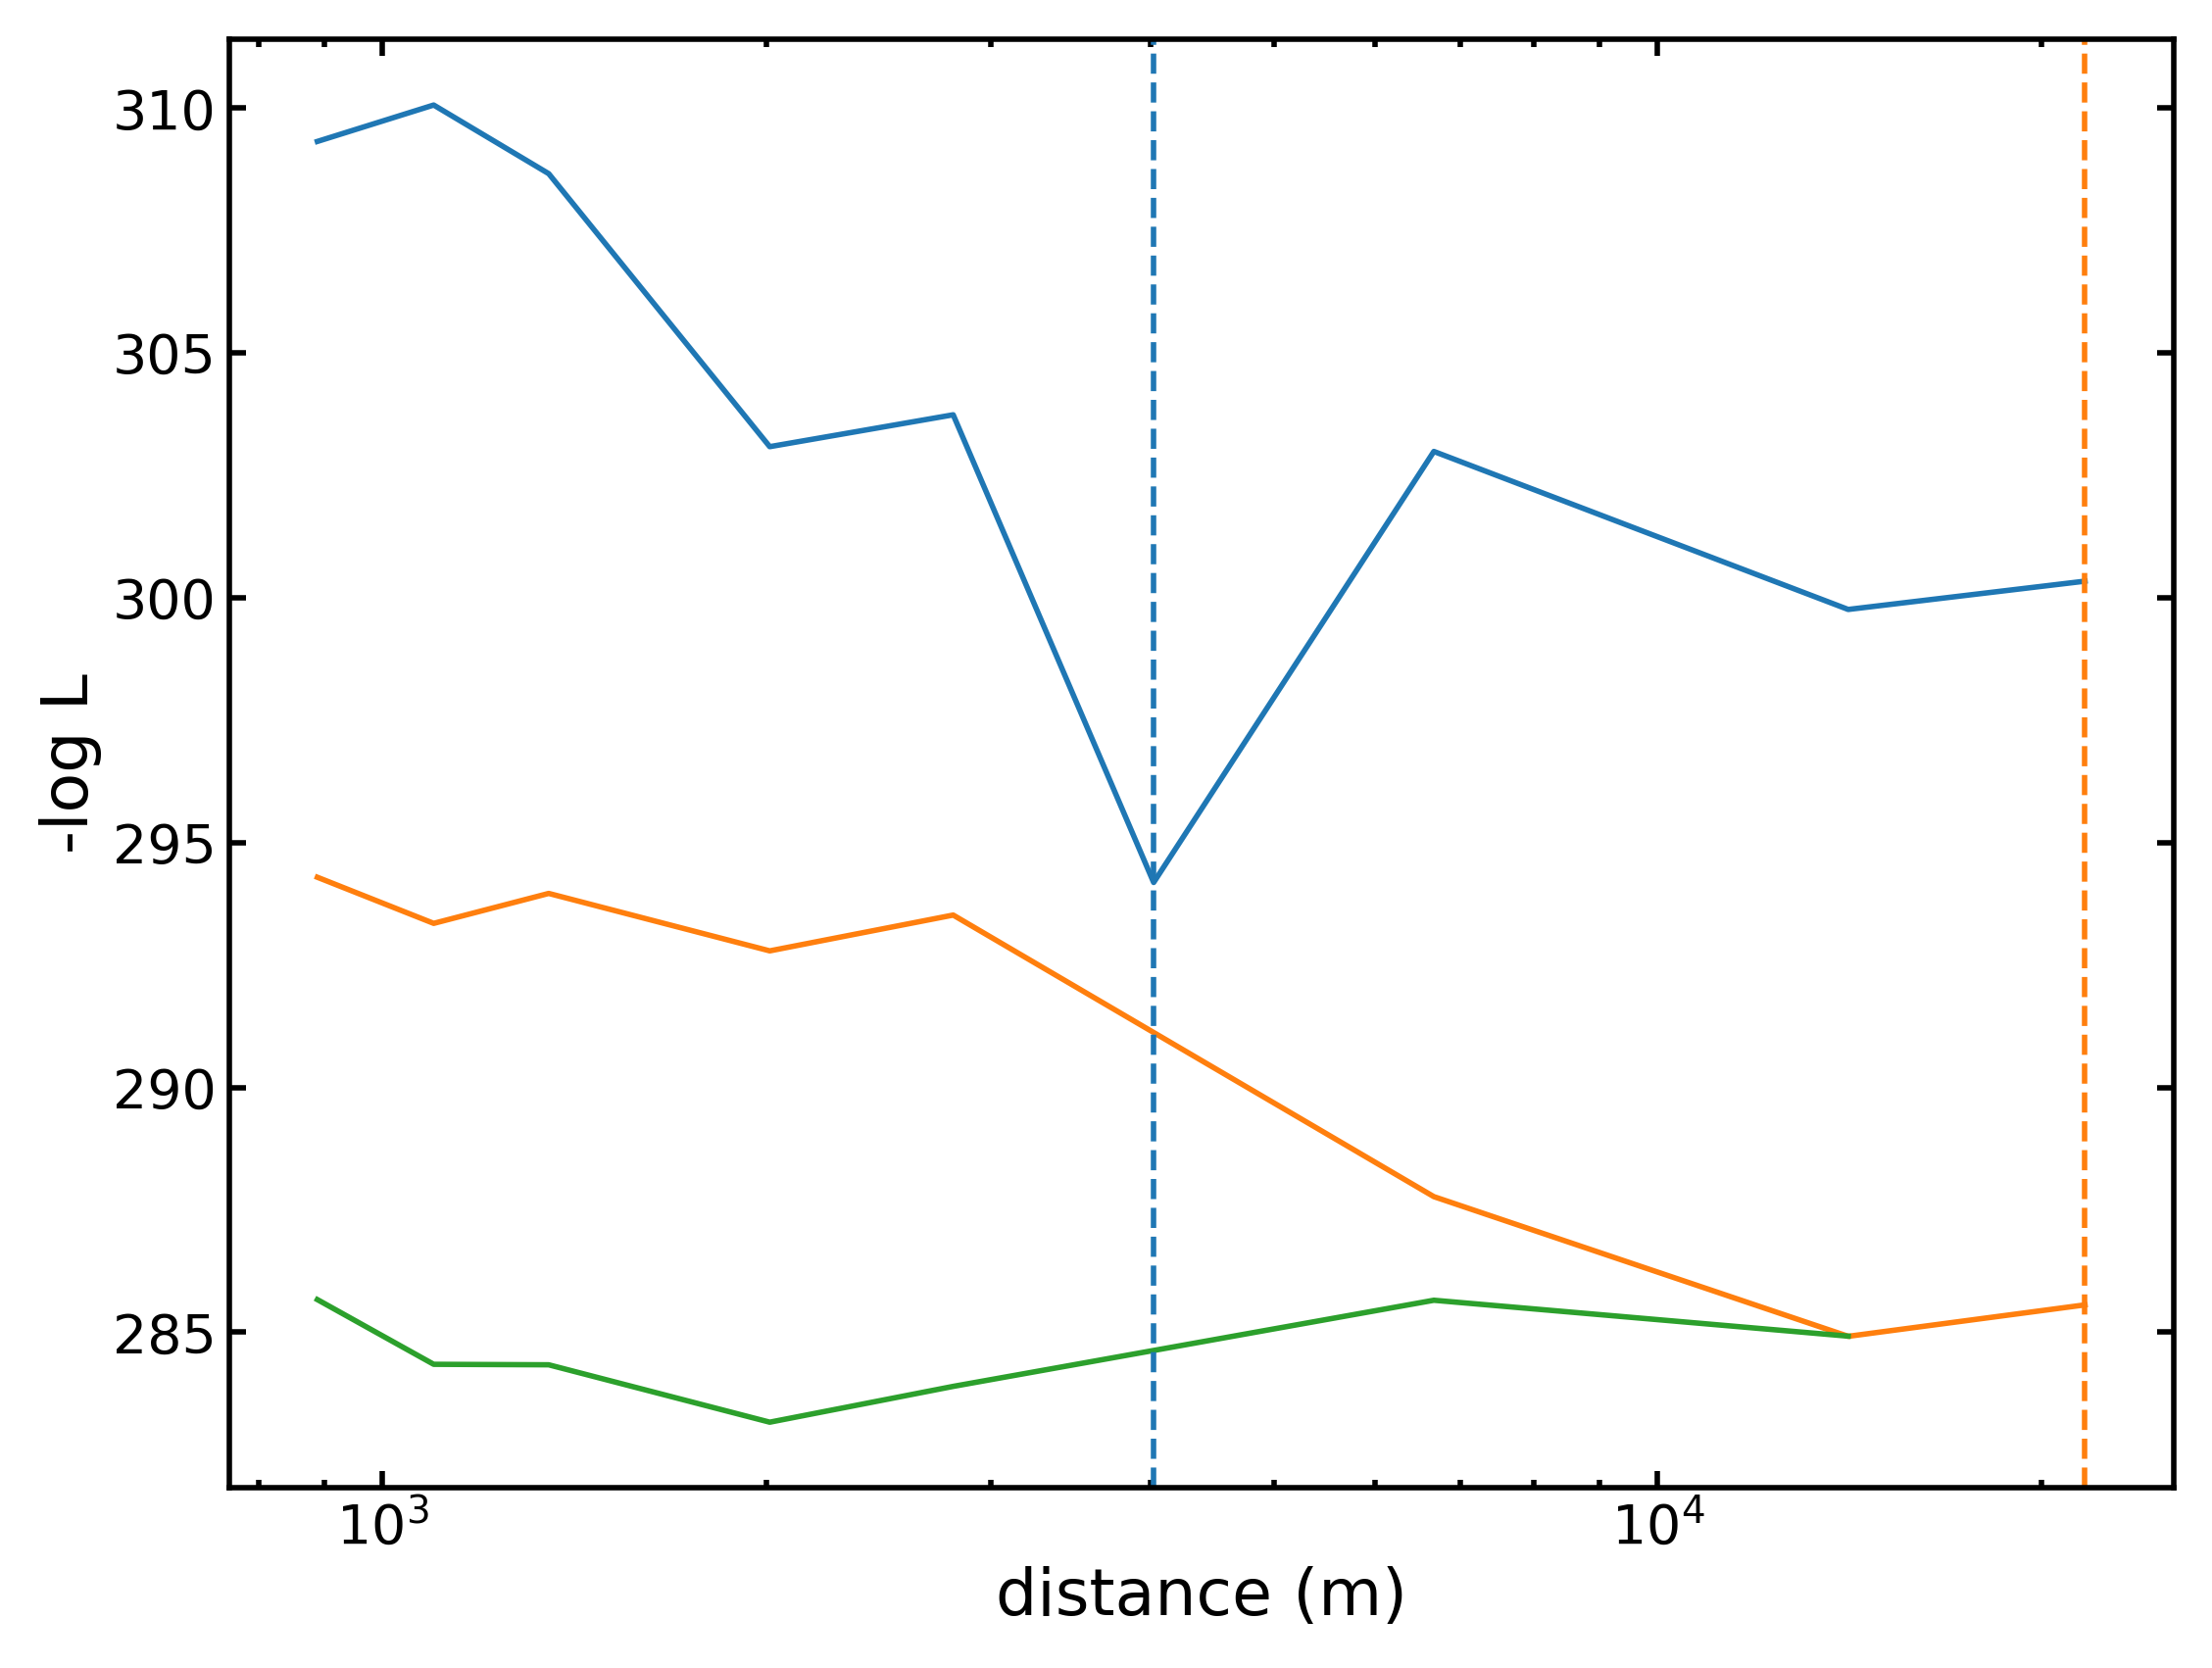

In [125]:
plt.figure()
for key, values in sorted(likelihoods.items(), key = lambda x:x[0]):
    x,y = zip(*values)
    plt.plot(x,y, color = 'C{}'.format(key-2))
for key, values in sorted(final_sizes.items(), key = lambda x:x[0]):
    plt.axvline(values, color = 'C{}'.format(key-2), ls = '--')
plt.xscale('log')
plt.xlabel('distance (m)')
plt.ylabel('-log L')

In [84]:
import itertools
from collections import Counter


def total_likelihood(source_target, cell_attractiveness, cell_p_change, return_all_values=False):
    '''
    Compute the total likelihood given all parameters.
    
    source_target: (list of lists)
        List of transitions.
    cell_attractiveness: (dict)
        Assigning attractiveness to each container
    cell_p_change: (list)
        Dictionary containing the probability to travel at any given level-distance for each location.
    return_all_values: (bool)
        If true, returns the likelihood associated to each transition.
    
    '''
    
    n_scales = len(source_target[0][0])
    unique, counts = np.unique(source_target, return_counts=True, axis=0)

    # Create sequence of origin-destinations
    change = unique[:, 0] != unique[:, 1]
    change_indexes = np.argmax([list(i)+[True] for i in change], axis=1)

    #Compute adjusted bernullis from dict
    unique_cell_p_change = np.array([cell_p_change[tuple(cell)] for cell in unique[:, 0]])

    
    #Compute cell attractiveness
    attractiveness_source = np.array([[cell_attractiveness[tuple(a[:n+1])] for n in range(n_scales)] for a in unique[:, 0]])
    attractiveness_target = np.array([[cell_attractiveness[tuple(a[:n+1])] for n in range(n_scales)] for a in unique[:, 1]])

    normalized_attr = attractiveness_target/(1 - attractiveness_source)
    normalized_attr = np.array([list(i)+[1] for i in normalized_attr])
    
    #Probabilities of scale changes

    
    p_s = np.clip(np.choose(change_indexes, unique_cell_p_change.T), 0.01, 0.99)

    #Compute prob of selecting a cell
    cell_probabilities_1 = np.choose(change_indexes, normalized_attr.T)    

    #Prob of selecting all other cells
    cell_probabilities_2 = np.array([np.prod(k[change_indexes[n]+1:]) for n,k in enumerate(attractiveness_target)])

    # Compute total likelihood
    if not return_all_values:
        r = p_s*cell_probabilities_1*cell_probabilities_2
        r = np.concatenate([[i]*c for i, c in zip(r, counts)])
        return sum(-np.log(r))
    
    else:
        r = p_s*cell_probabilities_1*cell_probabilities_2

        return (
            np.concatenate([[i]*c for i, c in zip(r, counts)]),    # array([6.02322201, 6.02322201, ..., 8.23421385, 4.28297013])  # probabilities
            np.concatenate([[i]*c for i, c in zip(unique, counts)]) # array([[[0, 3], [390, 2]], [[390, 2], [3, 21]], ... ])        # transitions
        )
def find_cell_p_change(source_target, n_scales, series):
    '''
    Find the probability of transitioning at given scale for all locations.
    
    Input
    -----
        source_target: numpy 2d-array (N, n_scales, n_scales)
            The original sequence of cell-ids
        n_scales: (int)
            Number of levels
        
    Output
    ------
        cell_p_change_dict: (dict)
            Dictionary with locations as keys, and prob of transitioning at any distance-level as values
            
        cell_p_change_dict_by_d: (dict)
           Dictionary with distance from home as key, prob of transitioning at any distance-level as value
        
    
    '''

    #Find where location changes
    change = source_target[:, 0] != source_target[:, 1]    
    
    #Find  most important location
    home = sorted(Counter([tuple(i) for i in series]).items(), key = lambda x:x[1], reverse = True)[0][0]
    
    #for each location find how many levels it is far from home    
    locations = np.unique(series,axis = 0)
    distance_from_home = np.argmax(locations!=np.array([home]*len(locations)), axis = 1)
    dictionary = dict(zip([tuple(i) for i in locations], distance_from_home))
    dictionary[tuple(home)] = n_scales
 

    #group all transitions by distance from home (of the source)
    source_target = sorted(source_target, key = lambda x:dictionary[tuple(x[0])])    
    groups = itertools.groupby(source_target, key=lambda x: dictionary[tuple(x[0])])
    
    
    #Create a dictionary of cell_p_change for each location.
    cell_p_change_dict = {}
    cell_p_change_dict_by_d = {}
    for key, group in groups:
        group = np.array(list(group))
        
        #At which index the transition occurs
        change = group[:, 0] != group[:, 1]
        change_indexes = np.argmax([list(i)+[True] for i in list(change)], axis=1)
        d = Counter(change_indexes)
        
        #Compute values and update dictionary
        cell_p_change = [d.get(n,0.001) for n in range(n_scales+1)]
        cell_p_change = [i/float(sum(cell_p_change)) for i in cell_p_change]
        
        cell_p_change_dict_by_d[n_scales - key] = cell_p_change
        
        for location in group[:,0]:
            cell_p_change_dict[tuple(location)] = cell_p_change
            
    #Fix eventually the last location in the series (it could be that it did not appear elsewhere)
    last_location = tuple(series[-1])
    cell_p_change_dict[last_location] = cell_p_change_dict_by_d[n_scales - dictionary[last_location]]
   
    
    return cell_p_change_dict, cell_p_change_dict_by_d


def compute_cell_attractiveness(series, cell_attractiveness, n=0):
    '''
    Recursive function to populate the `cell_attractiveness` dictionary.
    
    Input
    -----
        series: list 
            Sequence of locations
        cell_attractiveness: dict
            Dictionary to populate
        n: int 
            Level index
    '''
    series = sorted(series)
    n_scales = len(series[0])
    
    #group the elements by id (up to scale n) and count the number of occurances
    groups = itertools.groupby(series, key=lambda x: tuple(x[:n+1]))
    key_groups = [(key, len(list(group))) for key, group in groups]
    
    #update the dictionary: keys are cell ids, and values are attractiveness
    sum_values = sum([v for k, v in key_groups])
    key_groups = [(k, min(v/sum_values, 0.99)) for k, v in key_groups]

    cell_attractiveness.update(key_groups)
    
    #if we have not completed for all scales, apply this function recursively
    if n < n_scales - 1:
        for key, group in itertools.groupby(series, key=lambda x: tuple(x[:n+1])):
            compute_cell_attractiveness(list(group), cell_attractiveness, n+1)
def compute_likelihood(source_target, return_all_values=False):
    """Given a series of transitions (described as a hierarchy) compute the likelihood of the hiearchical partitioning.
    
    Input
    -----
        source_target : list of lists
            The series of trips in hierarchical description.
            The largest scale is the first value, the smallest scale is the last value.
    Output
    ------
        L: float
            The value of the likelihood.
        cell_attractiveness: dict
            Dictionary containing the attractiveness of cell_ids at all scales. 
        cell_p_change: dict
            Dictionary containing the out-transition probabilities for each container.
        cell_p_change_by_d: list of floats
            Dictionary containing the out-transition probabilities for each distance-from-home.
    """
    
    n_scales = len(source_target[0][0])
    series = source_target[:, 0].tolist() + [source_target[-1, 1].tolist()]

    # Estimate the cell attractiveness, like {(2, ): 0.8, (20, ): 0.1, ..., (2, 15): 0.9, (2, 4): 0.05, ...}
    cell_attractiveness = {}
    compute_cell_attractiveness(series, cell_attractiveness, 0)

    # Find cell p change from data
    cell_p_change, cell_p_change_by_d = find_cell_p_change(source_target, n_scales, series)    

    # Compute likelihood
    L = total_likelihood(source_target, cell_attractiveness, cell_p_change, return_all_values)
    return L, cell_attractiveness, cell_p_change, cell_p_change_by_d

def recover_parameters_from_fitted_trace(trace):
    '''Given a trace, recover parameters a and p.
    
    Input
    -----
    trace: list of lists (e.g.[ [1,2,3] , [1,2,1], ...., [2,1,1]])
           Sequence of locations in hierarchical form.
    
    
    Output
    ------
    nested_dictionary: (dict)
        Gives the attractiveness of each container.
    
    cell_p_change: (dict)
        Gives the probability of changing at any level-distance for each cell.
        
    '''
    
  
    #Create the source_target_list and compute the parameters of the model
    source_target = np.stack([trace[:-1], trace[1:]], axis=1)
    (proba_dist, proba_dist_counts), cell_attractiveness, cell_p_change, _ = compute_likelihood(source_target, return_all_values=True)

    #Create nested dictionary
    nested_dictionary = []
    items = sorted(cell_attractiveness.items(), key = lambda x:len(x[0]))
    for group1 in itertools.groupby(items,lambda x:len(x[0])):
        scale = group1[0]
        new_group = sorted(list(group1[1]), key= lambda x:x[0][:scale-1])
        new_dict = dict()
        for group2 in itertools.groupby(new_group,lambda x:x[0][:scale-1]):
            new_dict[group2[0]] = dict(group2[1])
        nested_dictionary.append(new_dict)
    return nested_dictionary, cell_p_change

def generate_trace(nested_dictionary, cell_p_change, size, initial_position = None):
    '''
    Generate a synthetic trace starting from a sequence of locations with the corresponding scale structure
    
    Input
    -----
    nested_dictionary: (dict)
        Gives the attractiveness of each container.
    cell_p_change: (dict)
        Gives the probability of changing at any level-distance for each cell.
    size: (int)
        Length of the sythethic sequence.
    initial position: (list)
        Initial position
 

    Output
    ------
    synthetic_trace: list of lists (e.g.[ [1,2,3] , [1,2,1], ...., [2,1,1]])
    
    '''
    
    #Recover parameters
    traces_len = int(size)
    n_scales = len(list(cell_p_change.values())[0]) - 1


    #Initialize synthetic trace
    if initial_position==None:
        locs = range(len(cell_p_change.keys()))
        l = np.random.choice(locs)
        initial_position = list(cell_p_change.keys())[l]
        
    L = tuple(initial_position) #current cell
    synthetic_series = [L[-1]] #sequence of cells
    scale_change = cell_p_change[L] #current p_change

    
    while(len(synthetic_series)<traces_len):
        #Iterate through steps

        #Select level
        change = np.random.choice(range(n_scales+1), p = scale_change)
       
    
        if change==n_scales:
            new_cell = L


        else:
            #Move
            attractiveness = nested_dictionary[change][L[:change]]
            new_cell = L[:change+1]

            #Select new_cell
            possible_cells = [i for i in attractiveness.items() if i[0]!=new_cell]
            if len(possible_cells)==0:
                continue;
                
            k, v = list(zip(*list(possible_cells)))
            new_cell = k[np.random.choice(range(len(v)), p = np.array(list(v))/sum(list(v)))]
                
            scale=change+1
            while scale<n_scales:
                attractiveness = nested_dictionary[scale][new_cell]
                k, v = list(zip(*list(attractiveness.items())))
                new_cell = k[np.random.choice(range(len(v)), p = np.array(list(v))/sum(list(v)))]
                scale+=1
                
        #Update values
        synthetic_series.append(new_cell[-1])
        L = new_cell
        scale_change = cell_p_change[L]

    return synthetic_series
    
#recover parameters
nested_dictionary, cell_p_change = recover_parameters_from_fitted_trace(final_series)

new_trace = generate_trace(nested_dictionary, cell_p_change, 50, initial_position=final_series[-1])

In [85]:
len(new_trace)

50

In [86]:
unique_locs_geom.loc_id.values

array([ 9167,  9388,  9504,  9521,  9573,  9595,  9596,  9609,  9616,
       10778, 11024, 12445, 12447, 12450, 12591, 12592, 12594, 12595,
       12615, 12819, 12822, 12824, 14492, 14561], dtype=int64)

In [63]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os

from tqdm import tqdm
from collections import defaultdict, Counter

from shapely import wkt
from sklearn.preprocessing import OrdinalEncoder

from utils.utils import load_data, _split_dataset

In [64]:
def get_train_test_mech(sp, all_locs=None):
    sp.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)
    # sp.drop(columns={"started_at", "finished_at"}, inplace=True)
    sp["idx"] = sp.groupby("user_id").cumcount().add(1)

    # encoder user, 0 reserved for padding
    enc = OrdinalEncoder(dtype=np.int64)
    sp["user_id"] = enc.fit_transform(sp["user_id"].values.reshape(-1, 1)) + 1

    # split the datasets, user dependent 0.7, 0.2, 0.1
    train_data, vali_data, test_data = _split_dataset(sp)

    # encode unseen locations in validation and test into 0
    enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
        all_locs["loc_id"].values.reshape(-1, 1)
    )
    # add 1 to account for 0 padding
    all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

    train_data["location_id"] = enc.transform(train_data["location_id"].values.reshape(-1, 1)) + 1
    vali_data["location_id"] = enc.transform(vali_data["location_id"].values.reshape(-1, 1)) + 1
    test_data["location_id"] = enc.transform(test_data["location_id"].values.reshape(-1, 1)) + 1

    return train_data, vali_data, test_data, all_locs


def get_data_mech():
    sp = pd.read_csv(os.path.join("./data/sp_tiny.csv"), index_col="id")
    loc = pd.read_csv(os.path.join("./data/loc_s2_level10_14.csv"), index_col="id")

    sp = load_data(sp, loc)

    # get all possible locations
    all_locs = pd.read_csv("./data/s2_loc_visited_level10_14.csv", index_col="id")
    all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
    all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
    # transform to projected coordinate systems
    all_locs = all_locs.to_crs("EPSG:2056")

    train_data, vali_data, test_data, all_locs = get_train_test_mech(sp, all_locs=all_locs)
    print(
        f"Max loc id {all_locs.loc_id.max()}, min loc id {all_locs.loc_id.min()}, unique loc id:{all_locs.loc_id.unique().shape[0]}"
    )

    return train_data, vali_data, test_data, all_locs

train_df, vali_df, test_df, all_locs_df = get_data_mech()
train_vali_data = pd.concat([train_df, vali_df])
train_vali_data.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)

Max loc id 28741, min loc id 1, unique loc id:28741
